In [2]:
import argparse
import importlib.util

import tensorflow as tf
import h5py
from sklearn.metrics import roc_curve
import pickle
import matplotlib.pyplot as plt

from alad_mod.alad import ALAD
from data.hlf_dataset_utils import *
from data.hlf_preprocessing import load
from evaluation.histogram_builder import *
from evaluation.plot_utils import *


In [3]:
result_path = '/home/oliverkn/pro/alad_6021/2_l16_1'
model_file = 'model-10000000'

print('loading alad')

# loading config
spec = importlib.util.spec_from_file_location('config', os.path.join(result_path, 'config.py'))
config_alad = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_alad)

# loading preprocessor
preprocessor = load(os.path.join(result_path, 'preprocessor.pkl'))

# loading alad
tf.reset_default_graph()
ad = ALAD(config_alad, tf.Session())
ad.load(os.path.join(result_path, model_file))


loading alad


W1017 14:13:42.757784 140114389374784 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1017 14:13:42.802426 140114389374784 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:29: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1017 14:13:42.806784 140114389374784 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:44: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1017 14:13:42.807845 140114389374784 deprecation.py:323] From /home/oliverkn/pro/alad_6021/2_l16_1/config.py:81: dense (from te

In [4]:
file_mc = '/home/oliverkn/pro/wjets_dyjets_mix/data.hdf5'
file_ttbar = '/home/oliverkn/pro/9588/data.hdf5'

x_mc = h5py.File(file_mc, "r")['data']
x_ttbar = h5py.File(file_ttbar, "r")['data']

/home/oliverkn/pro/pycharm/venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


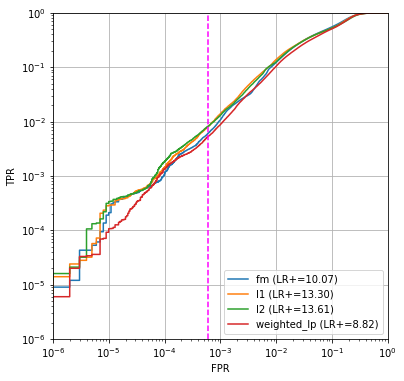

In [8]:
target_fpr = 600e-6
n_max = int(1e6)

x_mc_transformed = preprocessor.transform(x_mc[:n_max])
x_ttbar_transformed = preprocessor.transform(x_ttbar[:n_max])

mc_scores = ad.compute_all_scores(x_mc_transformed)
ttbar_scores = ad.compute_all_scores(x_ttbar_transformed)

y = np.concatenate([np.zeros_like(mc_scores[0]), np.ones_like(ttbar_scores[0])])
score_names = ['fm', 'l1', 'l2', 'weighted_lp']
fig, ax = plt.subplots(1, figsize=(6,6))

for j, name in enumerate(score_names):
    score = np.concatenate([mc_scores[j], ttbar_scores[j]])
    fpr, tpr, _ = roc_curve(y, score, pos_label=1)
    idx = np.argmax(fpr > target_fpr)
    lr_plus = tpr[idx] / fpr[idx]
    ax.loglog(fpr, tpr, label=name + ' (LR+=%.2f)' % lr_plus)
    
ax.axvline(target_fpr, ls='--', color='magenta')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.grid()
ax.set(xlim=(1e-6, 1), ylim=(1e-6, 1))
ax.legend()

plt.show()